In [3]:
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, device="cpu", max_len = 100):
        super().__init__()
        self.pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).type(torch.float32)
        tmp = torch.arange(0,d_model,2)
        den = 1/torch.pow(torch.ones(int(d_model/2))*max_len,2*tmp/d_model)
        den = den.unsqueeze(0)
        self.pe[:,0::2] = torch.sin(torch.matmul(pos,den))
        self.pe[:,1::2] = torch.cos(torch.matmul(pos,den))
        self.pe = self.pe.to(device)

    def forward(self, x):
        # scale = self.pe.shape[1]**0.5
        return x + self.pe[:x.shape[1],:]

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device):
        super(TransformerModel, self).__init__()
        # embed_dim = head_dim * num_heads?

        self.output_size = output_size

        self.input_fc = nn.Linear(input_size, d_model)
        self.output_fc = nn.Linear(input_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, device)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            batch_first=True,
            dropout=dropout,
            device=device
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            dim_feedforward=4 * d_model,
            batch_first=True,
            device=device
        )
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=encoder_num_layers)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=decoder_num_layers)
        self.fc = nn.Linear(output_size * d_model, output_size)
        self.fc1 = nn.Linear(seq_len * d_model, d_model)
        self.fc2 = nn.Linear(d_model, output_size)

    def forward(self, x):
        # print(x.size())  # (256, 24, 7)
        y = x[:, -self.output_size:, :]
        # print(y.size())  # (256, 4, 7)
        x = self.input_fc(x)  # (256, 24, 128)
        x = self.pos_emb(x)   # (256, 24, 128)
        x = self.encoder(x)
        # 不经过解码器
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        out = self.fc2(x)

        # y = self.output_fc(y)   # (256, 4, 128)
        # out = self.decoder(y, x)  # (256, 4, 128)
        # out = out.flatten(start_dim=1)  # (256, 4 * 128)
        # out = self.fc(out)  # (256, 4)

        return out

In [4]:
import pandas as pd
import sys


df = pd.read_csv("./dataset/Delaware.csv")
# df = df[df.REGION == "Delaware"]

df_use = df[["REGION", "YEAR", "WEEK", "ili_ratio"]]
df_use.index = range(len(df_use))

df_use = (df_use.loc[:, ["ili_ratio"]])  # 只用ili_ratio
df_use

,ili_ratio
0,0.001001
1,0.003686
2,0.003370
3,0.004605
4,0.002223
...,...
624,0.011423
625,0.009824
626,0.009270
627,0.012565


In [5]:
df = pd.read_csv("./dataset/covid19/france_new_cases.csv")

df_use = df[["New_cases"]]
df_use = df_use[:660]
df_use.index = range(len(df_use))

df_use

,New_cases
0,73
1,133
2,184
3,107
4,410
...,...
655,48473
656,14684
657,72634
658,79567


In [6]:
df = pd.read_csv("./dataset/covid19/france_new_cases _temp.csv")

df_use = df[["New_cases", "tavg"]]
df_use = df_use[:660]
df_use.index = range(len(df_use))

df_use

,New_cases,tavg
0,73,9.1
1,133,7.4
2,184,7.8
3,107,8.9
4,410,8.5
...,...,...
655,48473,3.9
656,14684,2.5
657,72634,2.5
658,79567,6.7


In [ ]:
df = pd.read_csv('./dataset/elec/oneminute.csv')

df_use = df[['p']]
df_use.index = range(len(df_use))
df_use = df_use[:5000]

In [7]:
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import numpy as np
import torch

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def nn_seq_us(batch_size, step):
    print('data processing...')
    dataset = df_use
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.85)]
    test = dataset[int(len(dataset) * 0.85):len(dataset)]
    m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])

    def process(data, batch_size, shuffle):
        load = data[data.columns[:]]
        print(load.values)
        load = load.values
        data = data.values.tolist()
        load = (load - n) / (m - n)

        seq = []
        for i in range(len(data) - step):
            train_seq = []
            train_label = []
            for j in range(i, i + step):
                x = [load[j]]
                train_seq.append(x)
            # for c in range(2, 8):
            #     train_seq.append(data[i + step][c])
            train_label.append(load[i + step])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        # print(seq[-1])
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    data_train = process(train, batch_size, True)
    data_validate = process(val, batch_size, True)
    data_test = process(test, batch_size, False)

    return data_train, data_validate, data_test, m, n

In [8]:
from torch.optim.lr_scheduler import StepLR as StepLR
from tqdm import tqdm
from copy import deepcopy

def get_val_loss(model, data_validate, loss_function, device):
    model.eval()
    val_loss = []
    for (seq, label) in data_validate:
        seq = seq.to(device)
        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        val_loss.append(loss.item())

    return sum(val_loss)/len(val_loss)# MSE


def transformer_train(data_train, data_validate, path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size=1, hidden_size=10, num_layers=2, output_size = 1, batch_size = 5, optimizer = 'adam', max_epochs = 20, lr = 0.01, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    weight_decay = 0.00005
    step_size = 5
    gamma = 0.1


    model = TransformerModel(input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device).to(device)

    loss_function = nn.MSELoss().to(device)
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 10

    loss = 10086
    min_train_loss = 10

    for epoch in range(max_epochs):
        train_loss = []
        for (seq, label) in data_train:
            optimizer.zero_grad()

            seq = seq.to(device)
            seq.resize_(batch_size, step, input_size)

            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        scheduler.step()

        # validation

        # val_loss = get_val_loss(model, data_validate, loss_function, device)
        # print(val_loss, min_val_loss)
        # if epoch > min_epochs and val_loss < min_val_loss:
        #     min_val_loss = val_loss
        #     best_model = deepcopy(model)
        #     print(type(model))
        #
        # if epoch % 10 == 0:
        #     print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))

        if epoch > min_epochs and loss < min_train_loss:
            min_train_loss = loss
            best_model = deepcopy(model)
            print(type(model))

        if epoch % 10 == 0:
            print('epoch {:03d} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))


        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

In [12]:
from itertools import chain
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def get_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# def lstm_test(data_test, path, m, n, input_size = 1,  hidden_size = 10, num_layers = 2, output_size = 1, batch_size = 5, device = torch.device('cpu')):
def transformer_test(data_test, path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device):
    pred = []
    y = []
    print('loading models...')

    model = TransformerModel(input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device).to(device)

    loss_function = nn.MSELoss().to(device)

    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in data_test:
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        seq.resize_(batch_size, step, input_size)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n

    # print('mape:', get_mape(y, pred))
    # print('mse:', get_mse(y, pred))

    # plot
    x = [i for i in range(1, y.shape[0] + 1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    # plt.savefig("./new.png")
    plt.show()



def future_transformer_test(data_test, path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device):
    predict_length = 20

    pred = []
    y = []
    print('loading models...')

    model = TransformerModel(input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device).to(device)

    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')

    y_pred = 0
    seq = []
    label = []
    ss = [(seq, target) for (seq, target) in data_test]
    for i in range(len(ss)):
        label.append(ss[i][1][0])

    y = label

    # label = list(chain.from_iterable(label.tolist()))
    ss = ss[0]
    for i in range(predict_length):

        seq = ss[0].to(device)
        with torch.no_grad():
            y_pred = model(seq)
            # print(f'seq{seq};')
            for i in range(len(seq[0]) - 1):
                seq[0][i] = seq[0][i+1]
            seq[0][-1] = y_pred
            # print(f'pred: {y_pred}')
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    # print(seq)
    # for i in range(len(seq[0]) - 1):
    #     seq[0][i] = seq[0][i+1]
    # seq[0][-1] = y_pred[0]


    # print(f'y_pred is {y_pred}')

    y = []
    for i in range(len(label)):
        y.append(label[i].detach().numpy()[0])

    print(len(y))
    print(len(pred))


    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n

    # print('mape:', get_mape(y, pred))
    # print('mse:', get_mse(y, pred))


    # plot
    # x = [i for i in range(1, y.shape[0] + 1)]
    x = [i for i in range(1, predict_length+1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y[:predict_length])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    # x = [i for i in range(1, pred.shape[0] + 1)]
    x = [i for i in range(1, predict_length+1)]
    y_smooth = make_interp_spline(x, pred[:predict_length])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    # plt.savefig("./new.png")
    plt.show()



In [10]:
input_size=2
hidden_size=10
num_layers=2
output_size = 1
batch_size = 1
optimizer = 'adam'
max_epochs = 25
lr = 0.0005
# lr = 0.03

step = 32    # 每step_size个epoch调整一次学习率

seq_len = 32  #
d_model = 16

nhead = 2
dropout = 0.2

encoder_num_layers = 2
decoder_num_layers = 1


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model_path = './transformer_model/best_model_transformer.model'

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)

cpu
data processing...
[[7.3000e+01 9.1000e+00]
 [1.3300e+02 7.4000e+00]
 [1.8400e+02 7.8000e+00]
 [1.0700e+02 8.9000e+00]
 [4.1000e+02 8.5000e+00]
 [2.8600e+02 1.0300e+01]
 [3.7200e+02 1.2700e+01]
 [4.9600e+02 1.0900e+01]
 [5.8600e+02 9.0000e+00]
 [7.7300e+02 8.9000e+00]
 [8.3500e+02 1.0100e+01]
 [9.1600e+02 1.0200e+01]
 [1.2020e+03 1.0900e+01]
 [1.0750e+03 1.1600e+01]
 [1.3870e+03 1.2400e+01]
 [1.8400e+03 1.2000e+01]
 [1.5710e+03 1.0100e+01]
 [1.8410e+03 9.5000e+00]
 [1.5250e+03 9.2000e+00]
 [3.8100e+03 8.2000e+00]
 [2.4120e+03 7.1000e+00]
 [2.8970e+03 6.4000e+00]
 [3.8460e+03 8.0000e+00]
 [3.7480e+03 1.0000e+01]
 [4.6110e+03 8.2000e+00]
 [2.4910e+03 5.9000e+00]
 [4.3410e+03 7.5000e+00]
 [7.5000e+03 8.1000e+00]
 [4.7840e+03 8.0000e+00]
 [2.0660e+03 9.2000e+00]
 [5.2090e+03 1.0700e+01]
 [4.2210e+03 1.3200e+01]
 [1.8500e+03 1.2800e+01]
 [3.8810e+03 1.3800e+01]
 [3.7370e+03 1.4600e+01]
 [3.8690e+03 1.5300e+01]
 [4.2560e+03 1.5700e+01]
 [4.3330e+03 1.5400e+01]
 [3.1040e+03 1.4600e+01]
 [

C:\Temp\ipykernel_19856\2763421094.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_seq = torch.FloatTensor(train_seq)
D:\soft\Miniconda\envs\pytorch_practice_py38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 000 train_loss 0.05080009
epoch 010 train_loss 0.01993766
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.01991105


loading models...
predicting...


ValueError: Shapes of x (134,) and y (67,) are incompatible

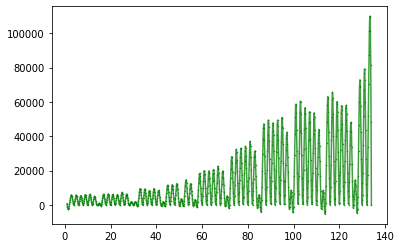

In [13]:
transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

In [ ]:
future_transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

In [79]:
df = pd.read_csv("./dataset/New York.csv")
# df = df[df.REGION == "Delaware"]

df_use = df[["REGION", "YEAR", "WEEK", "ili_ratio"]]
df_use.index = range(len(df_use))

df_use = (df_use.loc[:, ["ili_ratio"]])  # 只用ili_ratio
df_use

y = np.array(df_use['ili_ratio'])
y = y[:]

In [46]:
df = pd.read_csv("./dataset/covid19/france_new_cases.csv")

df_use = df[["New_cases"]]
df_use = df_use[:666]
df_use.index = range(len(df_use))


y = np.array(df_use['New_cases'])
y = y[:]

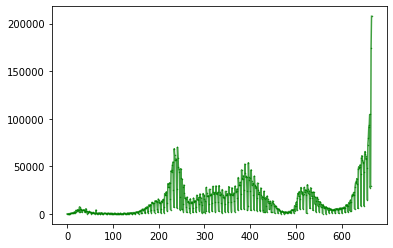

In [47]:
plt.plot(range(y.__len__()), y, c='green', marker='*', ms=1, alpha=0.75, label='')

In [13]:
y = np.array(df_use['New_cases'])
y = y[:]
plt.plot(range(y.__len__()), y, c='green', marker='*', ms=1, alpha=0.75, label='true')

KeyError: 'New_cases'

In [11]:
from models.model import Informer
model = Informer(1, 1, 1, 24, 24, 30)
model

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 512)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 512)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 512)
      )
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
   